# Predicting Heart Disease Using Machine Learning

This notebook looks into using various Pythin-based machine learning and data scirence libraries in an attempt to build a machine learning model capable of predicting weather someone has heart disease based on their medical attributes.

We're going to take the following approach:
1. Problem definition
2. Data
3. Evaluation 
4. Features
5. Modelling 
6. Experimentation 

## 1. Problem Definition

In a statement, 
> Given clinical parameters about a patient, can we predict whether or not they have heart disease?

## 2.Data 

The original data came from the Cleavland data from the UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/45/heart+disease

There is also a version of it available on Kaggle. 
https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci

## 3. Evaluation 

> If we can reach 95% accuracy at predicting whether or not a patient has heart disease during the proof of concept, we'll pursue the project.

## 4. Features

1. age: age in years
* sex: sex (1 = male; 0 = female)
* cp: chest pain type
    * Value 0: typical angina
    * Value 1: atypical angina
    * Value 2: non-anginal pain
    * Value 3: asymptomatic
* trestbps: resting blood pressure (in mm Hg on admission to the hospital)
* chol: serum cholestoral in mg/dl
* fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg: resting electrocardiographic results
    * Value 0: normal
    * Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
* thalach: maximum heart rate achieved
* exang: exercise induced angina (1 = yes; 0 = no)
* oldpeak = ST depression induced by exercise relative to rest
* slope: the slope of the peak exercise ST segment
    * Value 0: upsloping
    * Value 1: flat
    * Value 2: downsloping
* ca: number of major vessels (0-3) colored by flourosopy
* thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
* condition: 0 = no disease, 1 = disease (label)

## Preparing the tools 

We're going to use pandas, Matplotlib and Numpy for data analysis and manipulation 

In [1]:
# Import all the tools we need 

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline 

# Models from Scikit-Learn 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model evaluation 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [50]:
# warning handling
import warnings 
warnings.filterwarnings("ignore")

## Load data

In [2]:
df = pd.read_csv("heart-disease.csv")
df.shape #(rows, columns)

(303, 14)

## Data Exploration

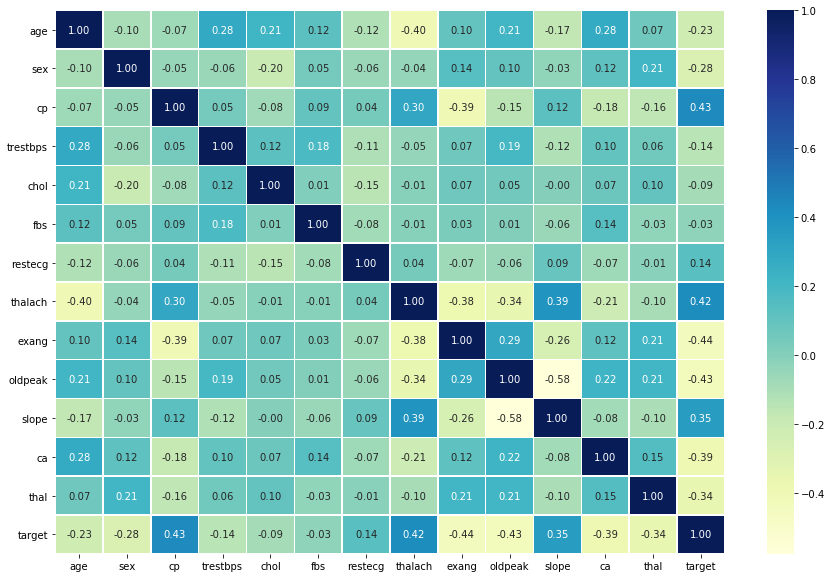

In [4]:
# Visual Correlation matrix 

corr_matrix = df.corr()
fig, ax= plt.subplots(figsize=(15,10))
ax=sns.heatmap(corr_matrix,
              annot=True,
              linewidth=0.5,
              fmt=".2f",
              cmap="YlGnBu")

## Modelling


In [5]:
# Split data into x and y
x = df.drop("target", axis=1)
y = df.target

np.random.seed(42)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

We are going to try 3 different machine learning models:
    1. Logistics Regression
    2. K-Nearest Neighbors Classifier 
    3. Random Forest Classifier

In [7]:
# Put models in dictionary

models = {"Logistic Regression": LogisticRegression(),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier()}

# Create function to fit and score models
def fit_and_score(models, x_train, x_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models. 
    models: a dict of different Scikit-learn machine learning models
    x_train: training data (no labels)
    x_test: testing data (no labels)
    y_train: training labels 
    y_test: testing labels
    """
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    
    for name, model in models.items():
        model.fit(x_train, y_train)
        model_scores[name]= model.score(x_test,y_test)
    return model_scores

In [51]:
model_scores = fit_and_score(models, x_train, x_test, y_train, y_test);
model_compare = pd.DataFrame(model_scores, index=["accuracy"]);
model_compare

,Logistic Regression,KNN,Random Forest
accuracy,0.885246,0.688525,0.836066


## Tuning the Logistic Regression Model

In [52]:
# Create a hyperparameter grid for LogisticRegression()
log_reg_grid = {"C" : np.logspace(-4,4,20),
                "solver" : ["liblinear"]} 

# Tune LogisticRegression
np.random.seed(42)

rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                           param_distributions = log_reg_grid,
                           cv=5,
                           n_iter=50,
                           verbose = True)
rs_log_reg.fit(x_train, y_train)
rs_log_reg.score(x_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


0.8852459016393442

## Evaluating the tuned machine learning classifier, beyond accuracy
 
    * ROC curve and Area under the curve (AUC)
    * Confusion matrix
    * Classification report
    * Precision
    * Recall
    * F1 score
    
Using cross-validation when possible

In [44]:
y_preds = rs_log_reg.predict(x_test)

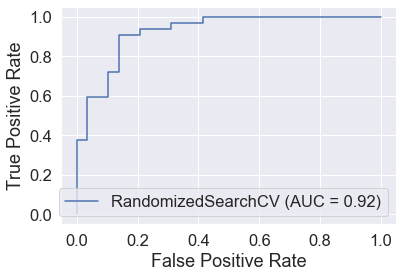

In [45]:
# ROC curve
plot_roc_curve(rs_log_reg, x_test, y_test);

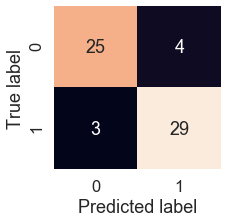

In [46]:
# Condusion matrix
sns.set(font_scale=1.5)

def plot_conf_mat(y_test,y_preds):
    """
    Plot a nice looking confusion matrix using Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                    annot = True,
                    cbar = False)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

plot_conf_mat(y_test, y_preds)

In [53]:
# Cross validated accuracy
cv_acc=cross_val_score(rs_log_reg, x, y, cv=5, scoring="accuracy");
cv_acc=np.mean(cv_acc)

# Cross validated precision
cv_precision=cross_val_score(rs_log_reg, x, y, cv=5, scoring="precision");
cv_precision=np.mean(cv_precision)

# Cross validated recall 
cv_recall=cross_val_score(rs_log_reg, x, y, cv=5, scoring="recall")
cv_recall=np.mean(cv_recall)

# Cross validated f1
cv_f1=cross_val_score(rs_log_reg, x, y, cv=5, scoring="f1")
cv_f1=np.mean(cv_f1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [42]:
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                          "Precision": cv_precision,
                          "Recall": cv_recall,
                          "F1": cv_f1},
                         index=[0])
cv_metrics

,Accuracy,Precision,Recall,F1
0,0.844645,0.820794,0.921212,0.867301


We did not achive the 95% accuracy score, however, this model has it's strengths and weaknesses. Not to be dismessed